In [1]:
import numpy as np


In [2]:
import pandas as pd

# Load RefFlat file
ref = pd.read_csv("refFlat", sep="\t", header=None)

# Set proper column names
ref.columns = [
    "gene_name", "transcript_name", "chrom", "strand",
    "tx_start_5prime", "tx_start_3prime",
    "cds_start", "cds_end",
    "exon_count", "exon_starts", "exon_ends"
]

# Extract strand-aware TSS
ref["tss"] = ref.apply(
    lambda row: row["tx_start_5prime"] if row["strand"] == "+" else row["tx_start_3prime"],
    axis=1
)

# Final TSS table for matching
tss_table = ref[["chrom", "tss"]].copy()


In [3]:

ref.head()

,gene_name,transcript_name,chrom,strand,tx_start_5prime,tx_start_3prime,cds_start,cds_end,exon_count,exon_starts,exon_ends,tss
0,Wdsub1,NM_001159636,chr2,-,59855193,59882606,59855270,59878527,11,"59855193,59858609,59861560,59862619,59862816,5...","59855275,59858750,59861737,59862726,59862857,5...",59882606
1,Rbm18,NM_001159635,chr2,-,36116078,36136704,36117814,36134247,6,"36116078,36120812,36122851,36127214,36134134,3...","36117974,36120898,36122938,36127251,36134263,3...",36136704
2,Prrc2b,NM_001159634,chr2,+,32151147,32234537,32182511,32230742,32,"32151147,32182457,32183122,32185344,32187480,3...","32151291,32182626,32183300,32185447,32187553,3...",32151147
3,Ildr2,NM_001164528,chr1,+,166254138,166316832,166254375,166310795,10,"166254138,166269304,166270498,166291415,166294...","166254466,166269637,166270618,166291472,166294...",166254138
4,Perm1,NM_172417,chr4,+,156215926,156221307,156217000,156220222,4,"156215926,156216716,156219740,156220109,","156215975,156219185,156219866,156221307,",156215926


In [4]:
# Extract strand-aware TSS
ref["tss"] = ref.apply(
    lambda row: row["tx_start_5prime"] if row["strand"] == "+" else row["tx_start_3prime"],
    axis=1
)

In [5]:
# Final TSS table for matching
tss_table = ref[["chrom", "tss"]].copy()


In [5]:
tss_table.shape

(47382, 2)

In [6]:

tss_table.isna().sum()

chrom    0
tss      0
dtype: int64

In [6]:
peaks = pd.read_csv("ATAC-seq/refined_ATAC.csv")

# Define peak center
peaks["peak_center"] = peaks["Summit"]

# Keep minimal amnt of columns for distance task
peaks = peaks[["ImmGenATAC1219.peakID", "chrom", "peak_center"]].copy()


In [18]:
#just to see if it worked 
peaks.head()


,ImmGenATAC1219.peakID,chrom,peak_center
0,ImmGenATAC1219.peak_1,chr1,3020786
1,ImmGenATAC1219.peak_2,chr1,3087226
2,ImmGenATAC1219.peak_3,chr1,3120109
3,ImmGenATAC1219.peak_4,chr1,3121485
4,ImmGenATAC1219.peak_5,chr1,3372787


In [19]:
peaks.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14865255 entries, 0 to 14865254
Data columns (total 3 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   ImmGenATAC1219.peakID  object
 1   chrom                  object
 2   peak_center            int64 
dtypes: int64(1), object(2)
memory usage: 340.2+ MB


In [7]:
# Create a dictionary: chrom → sorted array of TSSs on that chromosome
tss_dict = {
    chrom: np.sort(group["tss"].values)
    for chrom, group in tss_table.groupby("chrom")
}


In [8]:
# Function to find the nearest TSS to a peak center on the same chromosome

def fast_closest_tss(chrom, center):
    if chrom not in tss_dict:
        return np.nan # no TSS available for this chromosome
    tss_array = tss_dict[chrom]
     # Use binary search to find the insertion point
    idx = np.searchsorted(tss_array, center)
  
      # Edge cases: if center is before first or after last TSS
    if idx == 0:
        return tss_array[0]
    elif idx == len(tss_array):
        return tss_array[-1]
    else:
           # Pick the closest of the two surrounding TSS positions
        left = tss_array[idx - 1]
        right = tss_array[idx]
        return left if abs(center - left) < abs(center - right) else right


In [9]:
# Apply the closest-TSS function to each row of the peaks table

peaks["closest_tss"] = peaks.apply(
    lambda row: fast_closest_tss(row["chrom"], row["peak_center"]),
    axis=1
)

# Calculate absolute distance between peak center and closest TSS
peaks["distance_to_tss"] = np.abs(peaks["peak_center"] - peaks["closest_tss"])


In [15]:

#Check the head of the new columns
peaks[["peak_center", "closest_tss", "distance_to_tss"]].head(10)


,peak_center,closest_tss,distance_to_tss
0,3020786,3671498.0,650712.0
1,3087226,3671498.0,584272.0
2,3120109,3671498.0,551389.0
3,3121485,3671498.0,550013.0
4,3372787,3671498.0,298711.0
5,3399217,3671498.0,272281.0
6,3400115,3671498.0,271383.0
7,3416260,3671498.0,255238.0
8,3434092,3671498.0,237406.0
9,3434378,3671498.0,237120.0


In [16]:

print(peaks["distance_to_tss"].min())
print(peaks["distance_to_tss"].max())
print(peaks["distance_to_tss"].mean())


0.0
2012626.0
54800.2362037066


Minimum distance to TSS: 0.0 → At least one peak is exactly at a TSS.

Maximum distance: 2,012,626 bp → Some peaks are very far from any TSS (likely intergenic or distal enhancers).

Average distance: ~54,800 bp → Most peaks are within ~55kb of a TSS.

Now just gonna do some filtering

In [10]:
#checking dataset before filtering

print(peaks.shape)


(14865255, 5)


In [11]:
#filtering and checking the no after filtering 

filtered = peaks.dropna(subset=["distance_to_tss"])
print(filtered.shape)

#seeing how many dropped
print(peaks.shape[0] - filtered.shape[0])


(14859136, 5)
6119


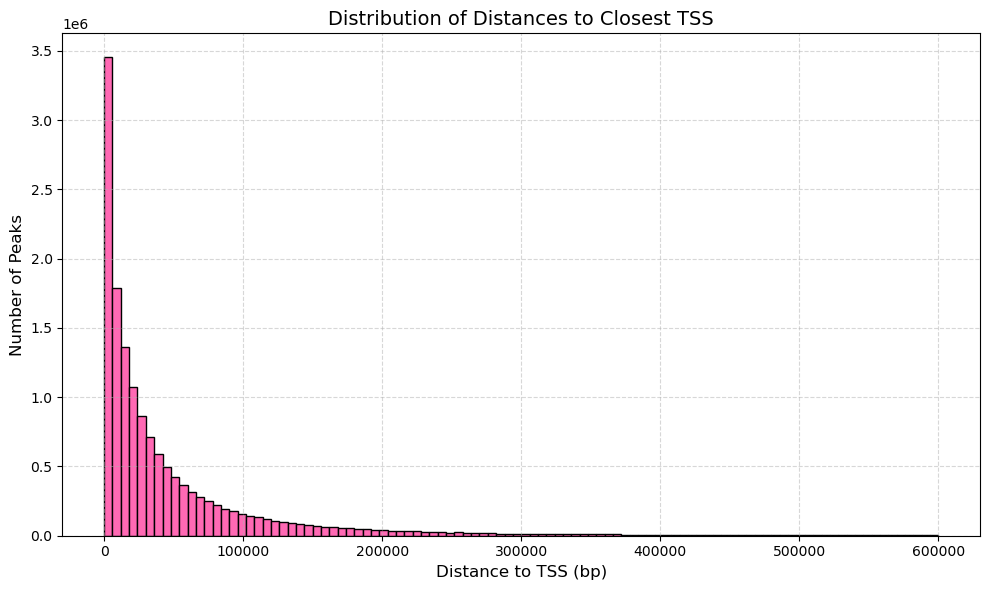

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Histogram with pink bars
plt.hist(filtered["distance_to_tss"], 
         bins=100, 
         color='hotpink', 
         edgecolor='black', 
         range=(0, 600_000))  # focus on distances <600k

# Titles and labels
plt.title("Distribution of Distances to Closest TSS", fontsize=14)
plt.xlabel("Distance to TSS (bp)", fontsize=12)
plt.ylabel("Number of Peaks", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



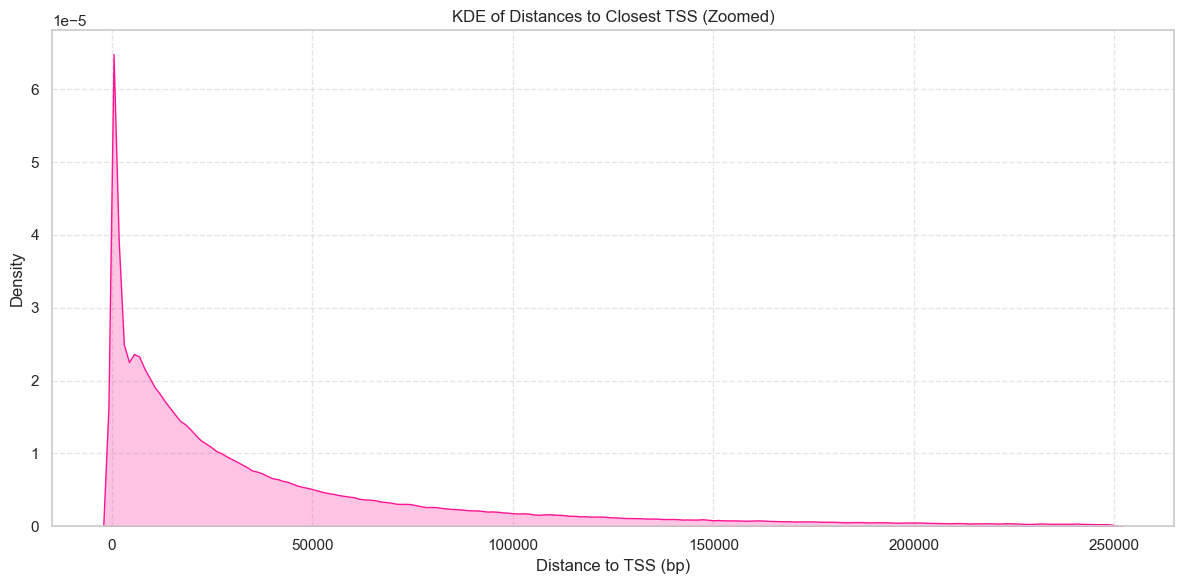

In [73]:
plt.figure(figsize=(12, 6))
sns.kdeplot(
    data=filtered.query("distance_to_tss <= 250000"),
    x="distance_to_tss",
    fill=True,
    color="deeppink",
    bw_adjust=0.4
)
plt.title("KDE of Distances to Closest TSS (Zoomed)")
plt.xlabel("Distance to TSS (bp)")
plt.ylabel("Density")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()




Now starting w task 2 

In [13]:
import pandas as pd

# Load full refined_ATAC.csv into a separate variable
peaks_full = pd.read_csv("ATAC-seq/refined_ATAC.csv")


In [3]:
peaks_full.sample(5, random_state=42)


,ImmGenATAC1219.peakID,chrom,Summit,mm10.60way.phastCons_scores,_-log10_bestPvalue,Included.in.systematic.analysis,TSS,genes.within.100Kb,Sample ID,Signal
14677155,ImmGenATAC1219.peak_324496,chr3,146419137,0.57,6.05,1.0,NaN,"Gm10636,Ssx2ip,Ctbs,Spata1,Gng5",MPP4.135+.BM,4.84
3553654,ImmGenATAC1219.peak_478085,chr9,23380962,0.04,2.88,1.0,NaN,NaN,T.DP.Th,2.45
7151701,ImmGenATAC1219.peak_487967,chr9,65561202,0.46,15.03,1.0,NaN,"Plekho2,Pif1,Rbpms2",Treg.4.25hi.Sp,1.49
4690420,ImmGenATAC1219.peak_77066,chr11,58168520,0.30,5.57,1.0,Gemin5,"Cnot8,Gemin5,Mrpl22,Gm12250,Igtp,Irgm2",T.4.Nve.Sp,9.81
14640066,ImmGenATAC1219.peak_287407,chr2,144011582,0.24,46.44,1.0,NaN,"Dstn,Rrbp1,Banf2",MPP4.135+.BM,64.77


In [4]:
peaks_full.isna().sum()


ImmGenATAC1219.peakID                     0
chrom                                     0
Summit                                    0
mm10.60way.phastCons_scores               0
_-log10_bestPvalue                        0
Included.in.systematic.analysis     5153764
TSS                                14450787
genes.within.100Kb                  2461665
Sample ID                                 0
Signal                                    0
dtype: int64

In [14]:
#checking if all peakIDs are unique (they aren't bc if they were the number below wouldve been the same)
print(len(peaks_full))
print(peaks_full["ImmGenATAC1219.peakID"].nunique())


14865255
512595


In [15]:
# Group by peak ID and compute mean signal per peak
peaks_mean = peaks_full.groupby("ImmGenATAC1219.peakID").agg({
    "Signal": "mean",
    "Summit": "first",  # assuming summit = peak center
    "chrom": "first"    # needed to recompute distance
}).reset_index()

# Rename columns for clarity
peaks_mean.rename(columns={
    "Signal": "mean_signal",
    "Summit": "peak_center"
}, inplace=True)


In [16]:
# Drop the unnecessary columns
peaks_mean_clean = peaks_mean.drop(columns=[
    "mm10.60way.phastCons_scores", 
    "_-log10_bestPvalue", 
    "Included.in.systematic.analysis", 
    "TSS", 
    "genes.within.100Kb"
], errors='ignore')  # errors='ignore' avoids crash if not present

# Reset the index so there's no row number column
peaks_mean_clean = peaks_mean_clean.reset_index(drop=True)


In [17]:
# Merge distance info from `peaks` into `peaks_mean_clean` using peakID
peaks_mean_clean = peaks_mean_clean.merge(
    peaks[["ImmGenATAC1219.peakID", "distance_to_tss"]],
    on="ImmGenATAC1219.peakID",
    how="left"
)


In [18]:
print(peaks_mean_clean.columns.tolist())


['ImmGenATAC1219.peakID', 'mean_signal', 'peak_center', 'chrom', 'distance_to_tss']


In [20]:
import seaborn as sns


<Axes: xlabel='distance_to_tss', ylabel='mean_signal'>

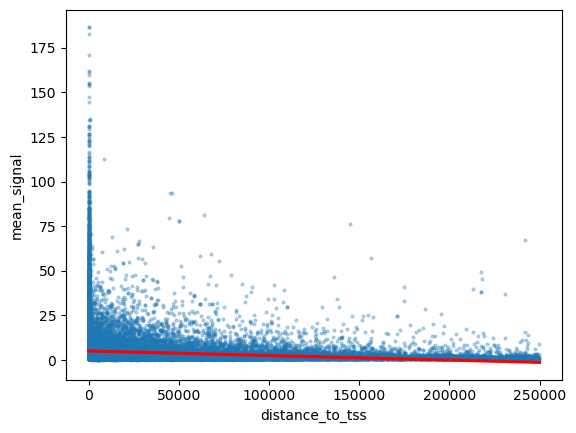

In [ ]:
# Downsample to 50k for plotting the other one was taking too long
sampled = filtered.sample(50000, random_state=42)

# Plot
sns.regplot(
    data=sampled,
    x="distance_to_tss",
    y="mean_signal",
    scatter_kws={"s": 4, "alpha": 0.3},
    line_kws={"color": "red"}
)
